# Simulating the formation of myosin clusters
In this notebook, I constructed a simple toy model to simulate the growth of myosin clusters via accretion. 

There are a series of random grids where myosin could bind (indices `0` to `numGrid`)

Each grid is initialized with an initial number of myosin & F-actin density.

In each iteration, a single myosin lands on a random grid based on a probability distribution, which is proportional to a) the F-actin density, and/or b) existing number of myosin on that grid. 

Repeat the process until all myosin have landed to a grid.

In [1]:
# Import packages
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from random import choices
import seaborn as sns
import random
from scipy.spatial import Delaunay
from numpy.random import default_rng
#import networkx as nx


## 1D myosin binding simulation

### Define functions to run simulation

In [35]:
# Define function that generates the underlying actin distribution
def GenActinThick(method, numGrid, *keys):
    rng = default_rng()
    if method == 'lognormal':
        ## Passed argument should be mu and sigma
        (mu, sigma) = keys
        ActinThick = rng.lognormal(mu, sigma, (numGrid))
    elif method == 'normal':
        ## Passed argument should be loc and scale
        (loc, scale) = keys
        ActinThick = rng.normal(loc, scale, (numGrid))
    elif method == 'uniform':
        ## Passed argument should be low and high
        (low, high) = keys
        ActinThick = rng.uniform(low, high, (numGrid))
    elif method == 'poisson':
        ## Passed argument should be lambda
        lam = keys
        ActinThick = rng.poisson(lam, (numGrid))
    else:
        raise ValueError('Method not supported!')
    return ActinThick.astype(int)

# Define function that generates the initial myosin cluster size
def GenMyoNum(method, numMyosin, *keys):
    rng = default_rng()
    if method == 'lognormal':
        ## Passed argument should be mu and sigma
        (mu, sigma) = keys
        myosinNum = rng.lognormal(mu, sigma, (numMyosin))
    elif method == 'normal':
        ## Passed argument should be loc and scale
        (loc, scale) = keys
        myosinNum = rng.normal(loc, scale, (numMyosin))
    elif method == 'uniform':
        ## Passed argument should be low and high
        (low, high) = keys
        myosinNum = rng.uniform(low, high, (numMyosin))
    elif method == 'poisson':
        ## Passed argument should be lambda
        lam = keys
        myosinNum = rng.poisson(lam, (numMyosin))
    else:
        raise ValueError('Method not supported!')
    return myosinNum.astype(int)

# Define function that runs simulation based on weights that are defined
def runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal, myosinBiasVal, ifsave, dwnsample):
    ### numGrid: number of grid points
    ### numMyosin: number of new myosin filaments to bind
    ### MyosinNum: initial myosin cluster size
    ### ActinThick: initial F-actin density
    ### actinBiasVal, myosinBiasVal: degree of affinity for new myosin to bind to actin or myosin

    MyosinNum = MyosinInit.copy()
    
    if ifsave:
        MyosinNumHist = np.zeros((numGrid, int(numMyosin/dwnsample)))

    # Define probability weights and draw random grid number that myosin lands
    for ii in range(numMyosin):
        index = np.arange(0, numGrid)
        actinBias = ActinThick * actinBiasVal
        myosinBias = MyosinNum * myosinBiasVal
        weights = np.ones((numGrid)) * (1+actinBias) * (1+myosinBias)
        #weights = weights * np.exp(-MyosinNum/ActinThick/myoCap)
        #weights = np.array(weights/sum(weights)) * np.exp(-np.maximum(0, np.array(MyosinNum)-myoCap))     ## Binding probability exponentially decays if exceeds binding capacity
        #weights[np.array(MyosinNum)>=myoCap] = 0   ###!!!!!!! Anything site that exceed capacity can't bind
        if len(np.nonzero(weights)[0]) == 0:    ### Terminate if no more available sites
            break
        else:
            landing = choices(index, weights)
            MyosinNum[landing] = MyosinNum[landing] + 1
        
        if ifsave:
            if ii%dwnsample == 0:
                MyosinNumHist[:, ii//dwnsample] = MyosinNum.T

    if ifsave:
        return MyosinNum, MyosinNumHist
    else:
        return MyosinNum

In [ ]:
    #### Archaic codes
        #numMerger = numGrid*activity
        #if numMerger>0 and numMerger<1:
        #    numMerger = np.random.random_sample()<numMerger
        
        #if numMerger > 0.0:
        #    numMerger = round(numMerger)
        #    merger_id = np.random.randint(0, numGrid-1, (numMerger))
        #    for edges in merger_id:
        #        MyosinNum[edges]=MyosinNum[edges]+MyosinNum[edges+1]
        #        MyosinNum[edges+1]=-1
        #        ActinThick[edges]=ActinThick[edges]+ActinThick[edges+1]
        #        ActinThick[edges+1]=-1
        #    MyosinNum = MyosinNum[MyosinNum!=-1]
        #    #print(MyosinNum.shape)
        #    ActinThick = ActinThick[ActinThick!=-1]
        #    #print(ActinThick.shape)
        #    numGrid -= numMerger

        #diff = np.abs(MyosinNum[1:] - MyosinNum[0:-1])
        #merge_cand = np.where(diff>merge_thresh)[0]
        #for jj in merge_cand:
        #    if np.random.rand()<Pmerge:
        #        (mergeId, tomerge) = (jj, jj+1)
        #        if MyosinNum[jj]<MyosinNum[jj+1]:
        #            (mergeId, tomerge) = (jj+1, jj)
        #        MyosinNum[mergeId]=MyosinNum[mergeId]+MyosinNum[tomerge]
        #        MyosinNum[tomerge]=0
        #        ActinThick[jj]=ActinThick[jj]+ActinThick[tomerge]
        #        ActinThick[tomerge]=1

        #if dis_rate > 0.0:
        #    numDisassemble = math.floor(dis_rate)
        #    if (dis_rate-numDisassemble) > np.random.random_sample():
        #        numDisassemble += 1
        #    dis_prob = np.array(MyosinNum) * np.exp(-np.array(MyosinNum))
        #    count = 0
        #    while count < numDisassemble:
        #        dis_id = choices(index, dis_prob)
        #        MyosinNum[dis_id] = 0
        #        count += 1

### Visualize initial conditions

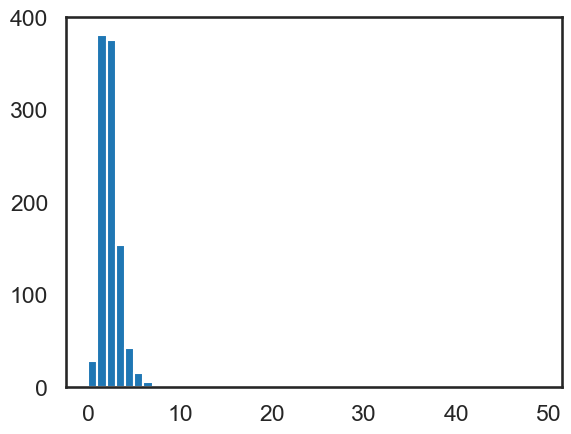

In [67]:
lognormNum = GenMyoNum('lognormal', 1000, 1.8, 0.6)
lognormNum1 = GenMyoNum('lognormal', 1000, 0.8, 0.4)
gaussNum = GenMyoNum('normal', 1000, 3, 0.6)
plt.hist(lognormNum1, bins = np.arange(50))
plt.show()

### Test visulization

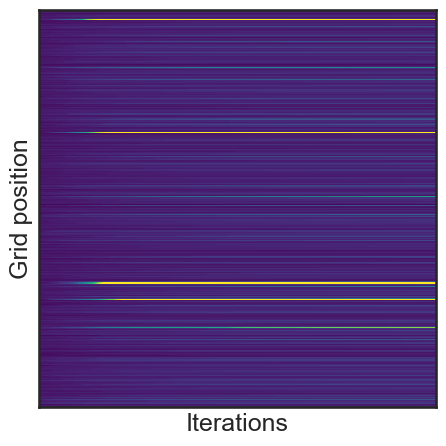

In [76]:
# Kymograph
numMyosin = 10000
numGrid = 1000
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
#myoCap = 30
actinBiasVal = .5
myosinBiasVal = .5
res, myoHist = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, 1, 10)

plt.figure()
plt.imshow(myoHist, cmap = 'viridis', vmin=0, vmax=40)
plt.xticks([])
plt.yticks([])
plt.xlabel('Iterations')
plt.ylabel('Grid position')
#plt.show()
plt.tight_layout()
plt.savefig('myosinBinding_kymograph_acBias_half_myoBias_half')

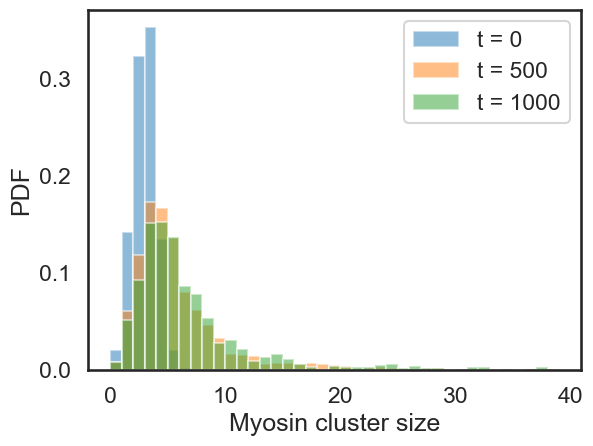

In [80]:
# Evolution of histogram
numMyosin = 10000
numGrid = 1000
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
#myoCap = 30
actinBiasVal = .5
myosinBiasVal = .5
res, myoHist = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, 1, 10)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(myoHist[:,0], bins = np.arange(40), density = True, alpha = 0.5, label = 't = 0')
plt.hist(myoHist[:,499], bins = np.arange(40), density = True, alpha = 0.5, label = 't = 500')
plt.hist(myoHist[:,999], bins = np.arange(40), density = True, alpha = 0.5, label = 't = 1000')
plt.legend()
plt.xlabel('Myosin cluster size')
plt.ylabel('PDF')
#plt.show()
plt.tight_layout()
plt.savefig('myosinBinding_histoEvolve_acBias_half_myoBias_half')

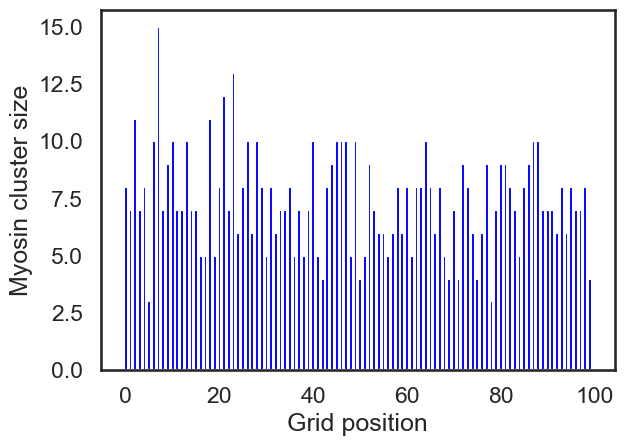

In [84]:
# Bar plot
numMyosin = 10000
numGrid = 1000
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
#myoCap = 30
actinBiasVal = 0
myosinBiasVal = 0
res, myoHist = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, 1, 10)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.bar(np.arange(100), myoHist[:100,500], color = 'blue')
plt.xlabel('Grid position')
plt.ylabel('Myosin cluster size')
#plt.show()
plt.tight_layout()
plt.savefig('myosinBinding_bar_acBias_0_myoBias_0')

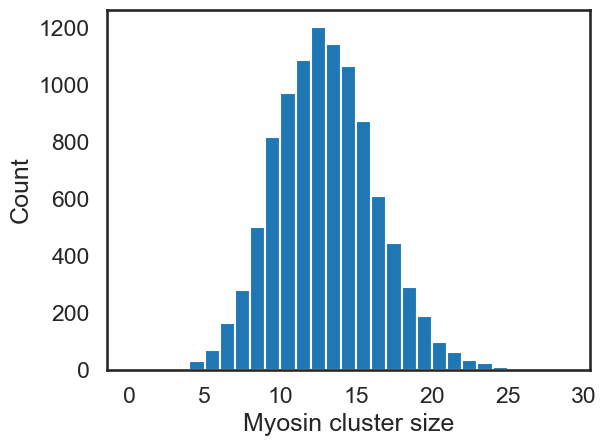

In [20]:
# Simulation ROCK-dependent cluster growth: no biases, random binding
numMyosin = 10000
numGrid = 1000
actinBiasVal = 0
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.
numSim = 10

allRes = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes[ii, :] = res

sns.set_style("white")
sns.set_context("talk")
plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(30))
plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.tight_layout()
#plt.savefig("myosinBinding_histogram_acBias_0_myoBias_0.png", dpi = 300)

## Accretion with myosin bias

0.694216842668997 0.0 10.2855195096737


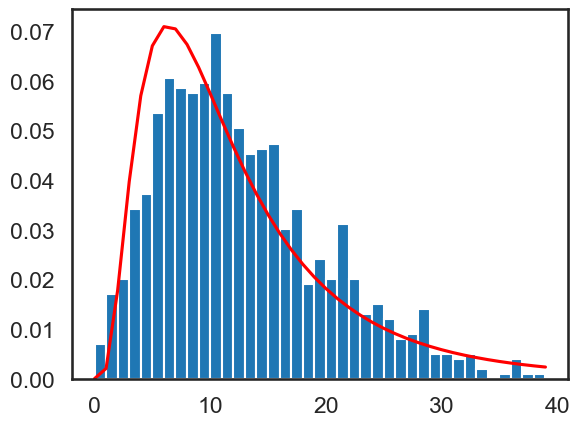

In [34]:
numMyosin = 10000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 0
myosinBiasVal = 1
ifsave = 0
dwnsample = 1


sns.set_style("white")
sns.set_context("talk")
plt.figure()


# Initialize and run simulation
ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
MyosinNum = GenMyoNum('normal', numGrid, 3, 1) 
res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, ifsave, dwnsample)

allData = np.reshape(res, (numGrid))
(s, loc, scale) = st.lognorm.fit(allData[allData>0], floc = 0)
print(s, loc, scale)
xfit = np.arange(40)
plt.hist(allData, bins = np.arange(40), density = True)
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')

#plt.xlabel("Myosin cluster size")
#plt.ylabel("Count")
#plt.legend()
#plt.tight_layout()
#plt.savefig("myosinBinding_histogramComp_acBias_0_mu_1_sigma_1_myoBiasComp.png", dpi = 300)

In [33]:
print(np.exp(np.log(scale)-s**2))

5.430551549737957


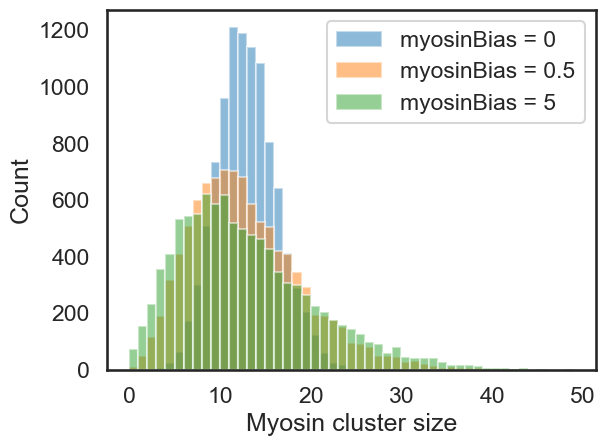

In [23]:
## Average over 10 simulations
# Simulation parameters
numMyosin = 10000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 0
myosinBiasVal = [0, .5, 5]
merge_thresh = 100000000
Pmerge = 0.

numSim = 10

sns.set_style("white")
sns.set_context("talk")
plt.figure()
#plt.rcParams['font.size'] = '16'
for ii in range(len(myosinBiasVal)):
    # Scan through myosinBiasVal
    countRes = np.zeros((numSim, 80))
    allRes = np.zeros((numSim, numGrid))
    for jj in range(numSim):
        # Initialize and run simulation
        ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
        MyosinNum = GenMyoNum('normal', numGrid, 3, 1) 
        res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal[ii], merge_thresh, Pmerge)
        allRes[jj, :] = res   # Number of myosin particles
    plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = "myosinBias = " + str(myosinBiasVal[ii]))

plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
#plt.savefig("myosinBinding_histogramComp_acBias_0_mu_1_sigma_1_myoBiasComp.png", dpi = 300)

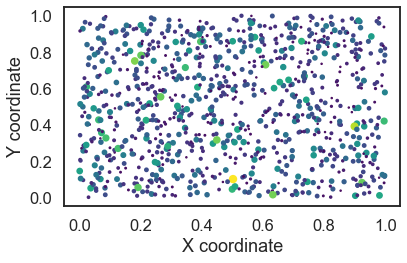

In [ ]:
### Visualization
res = runSimulation(numMyosin, mu, sigma, myoCap, actinBias, 0.5)
sns.set_style("white")
sns.set_context("talk")
plt.scatter(coordinates[:,0], coordinates[:,1], s = res, c = res, cmap = "viridis")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.tight_layout()
plt.savefig("myosinBinding_map_acBias_0_myoBias_0.5_mu_1_sigma_1.png", dpi = 300)

### Dependence on number of myosin

In [ ]:
numMyosin = 10000
numGrid = 1000
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
#myoCap = 30
actinBiasVal = 0
myosinBiasVal = 2
merge_thresh = 100000000
Pmerge = 0.
res1 = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
res2 = runSimulation(numGrid, numMyosin*3, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(res1[res1>=0], bins = np.arange(80), alpha = 0.5, label = '10000')
plt.hist(res2[res2>=0], bins = np.arange(80), alpha = 0.5, label = '30000')
plt.legend()
plt.show()

## Bias towards F-actin

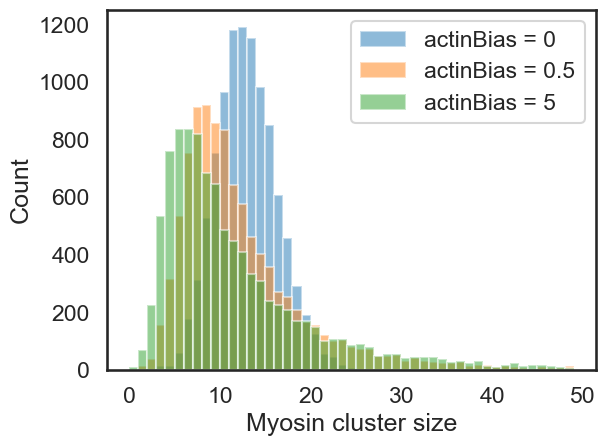

In [25]:
## Run simulation
# Simulation parameters
numMyosin = 10000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = [0, .5, 5]
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.

numSim = 10

sns.set_style("white")
sns.set_context("talk")
plt.figure()
#plt.rcParams['font.size'] = '16'
for ii in range(len(actinBiasVal)):
    numSim = 10
    countRes = np.zeros((numSim, 80))
    allRes = np.zeros((numSim, numGrid))
    for jj in range(numSim):
        # Run simulations
        ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
        MyosinNum = GenMyoNum('normal', numGrid, 3, 1) #GenMyoNum('lognormal', 1000, 1.8, 0.6)
        res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal[ii], myosinBiasVal, merge_thresh, Pmerge)
        allRes[jj, :] = res   # Number of myosin particles
    plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = "actinBias = " + str(actinBiasVal[ii]))

plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
#plt.savefig("myosinBinding_histogramComp_myoBias_0_mu_1_sigma_1_actinBiasComp.png", dpi = 300)

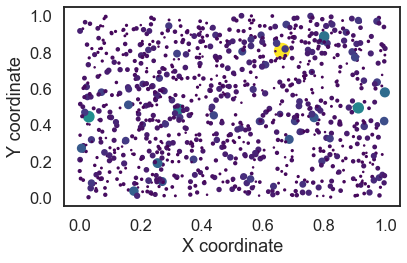

In [61]:
sns.set_style("white")
sns.set_context("talk")
plt.scatter(coordinates[:,0], coordinates[:,1], s = res, c = res, cmap = "viridis")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.tight_layout()
plt.savefig("myosinBinding_map_acBias_5_myoBias_0_mu_1_sigma_1.png", dpi = 300)

## Dependence on F-actin distribution

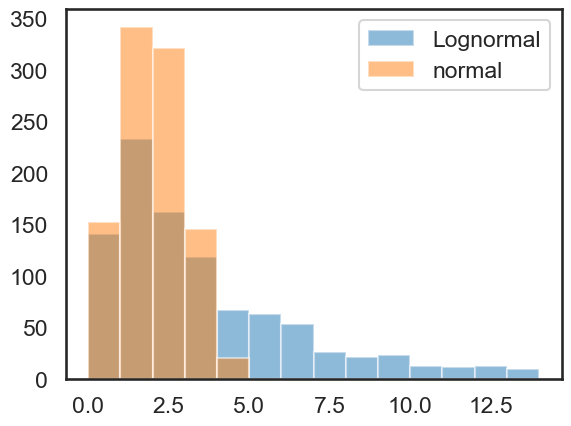

In [26]:
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(GenActinThick('lognormal', numGrid, 1, 1), bins = np.arange(15), alpha = 0.5, label = 'Lognormal')
plt.hist(GenActinThick('normal', numGrid, 2, 1), bins = np.arange(15), alpha = 0.5, label = 'normal')
#plt.hist(GenActinThick('uniform', numGrid, 0, 10), bins = np.arange(15), alpha = 0.5, label = 'normal')
plt.legend()
#plt.savefig("actin_dist_comp.png", dpi = 300)

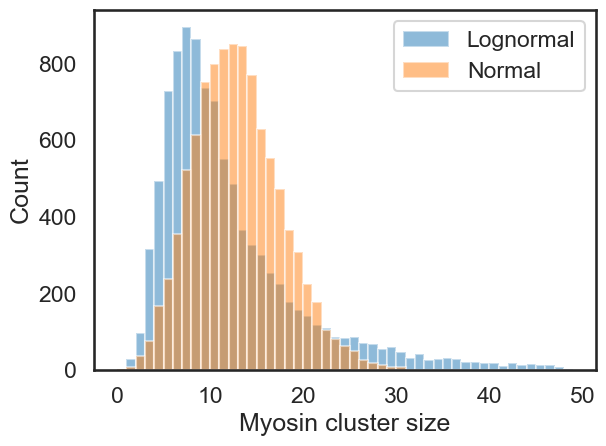

In [28]:
## Run simulation
# Simulation parameters
numMyosin = 10000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 1
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.

numSim = 10
    
allRes_LN = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_LN[ii, :] = res

allRes_N = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('normal', numGrid, 2, 1)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_N[ii, :] = res

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(np.reshape(allRes_LN, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = 'Lognormal')
plt.hist(np.reshape(allRes_N, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = 'Normal')
plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
#plt.savefig("", dpi = 300)

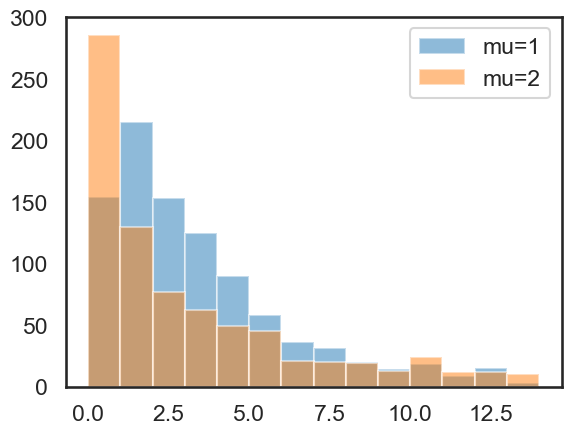

In [31]:
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(GenActinThick('lognormal', numGrid, 1, 1), bins = np.arange(15), alpha = 0.5, label = 'mu=1')
#plt.hist(GenActinThick('lognormal', numGrid, 1, 0.5), bins = np.arange(15), alpha = 0.5, label = 'mu=0.5')
plt.hist(GenActinThick('lognormal', numGrid, 1, 2), bins = np.arange(15), alpha = 0.5, label = 'mu=2')
plt.legend()
plt.savefig("actin_dist_comp.png", dpi = 300)

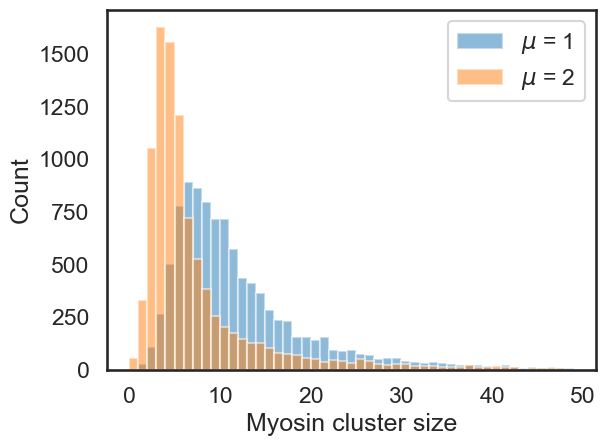

In [32]:
numMyosin = 10000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 1
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.

numSim = 10
    
allRes_1 = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_1[ii, :] = res

allRes_2 = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 2)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_2[ii, :] = res

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(np.reshape(allRes_1, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = '$\mu$ = 1')
plt.hist(np.reshape(allRes_2, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = '$\mu$ = 2')
plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("myosinBinding_histogramComp_myoBias_0_actinBias_1_mu_1_sigmaComp.png", dpi = 300)

## Actomyosin correlation

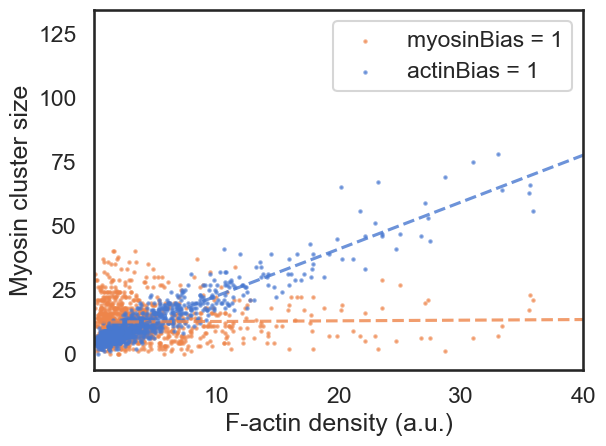

In [113]:
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
#myoCap = 1000   # Cap the number of myosin per site
merge_thresh = 100000000
Pmerge = 0.
numMyosin = 10000
numGrid = 1000

# Run simulations
resAcBias = runSimulation(numMyosin, numGrid, ActinThick, 1, 0, merge_thresh, Pmerge)
resMyoBias = runSimulation(numMyosin, numGrid, ActinThick, 0, 1, merge_thresh, Pmerge)

acFit = st.linregress(ActinThick, resAcBias)
myoFit = st.linregress(ActinThick, resMyoBias)

sns.set_style("white")
sns.set_context("talk")
co = sns.color_palette('muted')
xt = np.arange(ActinThick.max())
plt.figure()
plt.scatter(ActinThick, resMyoBias, s = 3, color=co[1], alpha = 0.6, label = 'myosinBias = 1')
plt.plot(xt, myoFit.intercept+myoFit.slope*xt, '--', color=co[1], alpha = 0.8)
plt.scatter(ActinThick, resAcBias, s = 3, color=co[0], alpha = 0.6, label = 'actinBias = 1')
plt.plot(xt, acFit.intercept+acFit.slope*xt, '--', color=co[0], alpha = 0.8)
#plt.rcParams['font.size'] = '16'
plt.xlabel("F-actin density (a.u.)")
plt.ylabel("Myosin cluster size")
plt.legend()
plt.xlim((0, 40))
plt.tight_layout()
plt.savefig("myosinBinding_actomyosinCorr_mu_1_sigma_1.png", dpi = 300)

## Coalescence

## Bias towards both F-actin and myosin

### Phase space

In [11]:
MyosinNum = GenMyoNum('normal', numGrid, 3, 1) 
sum(MyosinNum)

2498

In [78]:
import pandas as pd

numMyosin = 12000
numGrid = 2000
actinBiasVal = [0, 0.2, 0.5, 1, 5]
myosinBiasVal = [0, 0.2, 0.5, 1, 5]
ifsave = 0
dwnsample = 1

acBias = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
myoBias = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
mode_array = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
sigma_array = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
# Initialize and run simulation
for ii in range(len(actinBiasVal)):
    for jj in range(len(myosinBiasVal)):
        ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
        MyosinInit = GenMyoNum('lognormal', numGrid, 0.8, 0.4) #GenMyoNum('normal', numGrid, 3, 0.6) 
        res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal[ii], myosinBiasVal[jj], ifsave, dwnsample)

        # Save goodness of fit metrics
    

        # Save mu, sigma
        allData = np.reshape(res, (numGrid))
        (s, loc, scale) = st.lognorm.fit(allData[allData>0], floc = 0)
        idx = ii*len(actinBiasVal)+jj
        acBias[idx] = actinBiasVal[ii]
        myoBias[idx] = myosinBiasVal[jj]
        mode_array[idx] = np.exp(np.log(scale)-s**2)
        sigma_array[idx] = s

        # Save histogram
        sns.set_style("white")
        sns.set_context("talk")
        co = sns.color_palette('muted')
        plt.figure()
        xfit = np.arange(40)
        plt.hist(MyosinInit, bins = np.arange(40), color = co[0], density = True, label = 'Initial condition')
        plt.hist(allData, bins = np.arange(40), color = co[1], density = True, label = r'$\alpha$='+str(myosinBiasVal[jj])+r', $\beta$='+str(actinBiasVal[ii]))
        plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.savefig('myosinBinding_histogram_myoBias_'+str(myosinBiasVal[jj])+'_acBias_'+str(actinBiasVal[ii])+'.png', dpi = 300)
        plt.close()
    
        # Save actomyosin correlation
        acFit = st.linregress(ActinThick, res)
        sns.set_style("white")
        sns.set_context("talk")
        xt = np.arange(ActinThick.max())
        plt.figure()
        plt.scatter(ActinThick, res, s = 3, alpha = 0.6, label = r'$\alpha$='+str(myosinBiasVal[jj])+r', $\beta$='+str(actinBiasVal[ii]))
        plt.plot(xt, acFit.intercept+acFit.slope*xt, '--', color='red', alpha = 0.8)
        plt.xlabel("F-actin density (a.u.)")
        plt.ylabel("Myosin cluster size")
        plt.xlim((0, 40))
        plt.ylim((0, min(np.max(res), 100)))
        plt.legend()
        plt.tight_layout()
        plt.savefig('myosinBinding_actomyosinCorr_myoBias_'+str(myosinBiasVal[jj])+'_acBias_'+str(actinBiasVal[ii])+'.png', dpi = 300)
        plt.close()

df = pd.DataFrame({'alpha': myoBias, 'beta': acBias, 'mode': mode_array, 'sigma': sigma_array})
df.to_csv('params.csv')
#plt.xlabel("Myosin cluster size")
#plt.ylabel("Count")
#plt.legend()
#plt.tight_layout()
#plt.savefig("myosinBinding_histogramComp_acBias_0_mu_1_sigma_1_myoBiasComp.png", dpi = 300)

In [54]:
df

,alpha,beta,mode,sigma
0,0.0,0.0,6.386863,0.332523
1,0.1,0.0,5.907304,0.402334
2,0.3,0.0,5.509874,0.459776
3,0.5,0.0,5.174711,0.503087
4,0.0,0.1,5.985740,0.389910
5,0.1,0.1,5.271528,0.475196
6,0.3,0.1,4.616913,0.551871
7,0.5,0.1,4.244361,0.601536
8,0.0,0.3,5.054862,0.502745
9,0.1,0.3,4.063147,0.581286


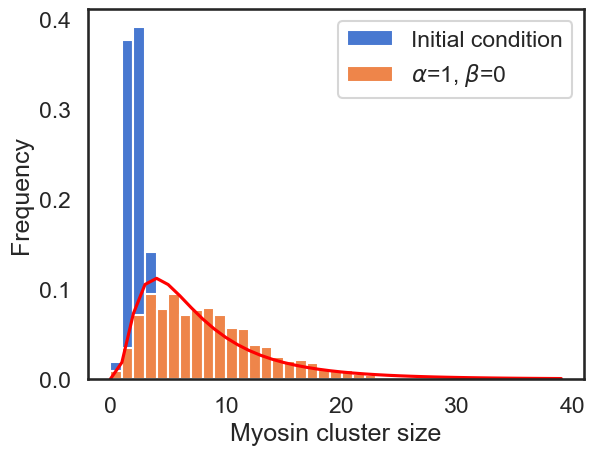

In [77]:
myosinBiasVal = 1
actinBiasVal = 0
res = runSimulation(2000, 12000, GenMyoNum('lognormal', 2000, 0.8, 0.4) , GenActinThick('lognormal', 2000, 1, 1), actinBiasVal, myosinBiasVal, 0, 1)
#res.tofile('myoNum.csv', sep=' ')
(s, loc, scale) = st.lognorm.fit(res[res>0], floc = 0)
sns.set_style("white")
sns.set_context("talk")
co = sns.color_palette('muted')
plt.figure()
xfit = np.arange(40)
plt.hist(GenMyoNum('lognormal', 2000, 0.8, 0.4), bins = np.arange(40), color = co[0], density = True, label = 'Initial condition')
plt.hist(res, bins = np.arange(40), color = co[1], density = True, label = r'$\alpha$='+str(myosinBiasVal)+r', $\beta$='+str(actinBiasVal))
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
plt.xlabel("Myosin cluster size")
plt.ylabel("Frequency")
plt.legend()

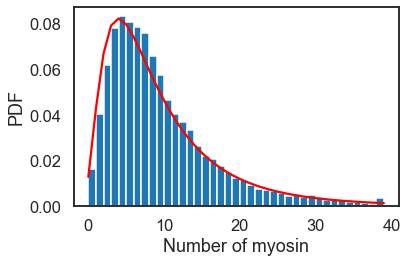

In [86]:
mu = 1   # Thickness of actin
sigma = 1
myoCap = 1000   # Cap the number of myosin per site
actinBias = .5
myosinBias = .3
numMyosin = 10000
numSim = 10

allRes = np.zeros((numSim, numGrid))
for ii in range(numSim):
    res = runSimulation(numMyosin, mu, sigma, myoCap, actinBias, myosinBias)
    allRes[ii, :] = res
    
allData = np.reshape(allRes, (numSim*numGrid))
(s, loc, scale) = st.lognorm.fit(allData, loc = 0)
xfit = np.arange(40)
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
sns.set_style("white")
sns.set_context("talk")
plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(40), density = True, stacked = True)
plt.xlabel("Number of myosin")
plt.ylabel("PDF")
plt.tight_layout()
plt.savefig("myosinBinding_histogram_acBias_0.5_myoBias_0.3_mu_1_sigma_1.png", dpi = 300)

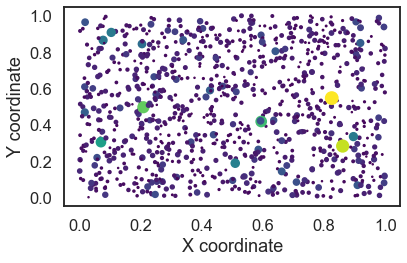

In [87]:
sns.set_style("white")
sns.set_context("talk")
plt.scatter(coordinates[:,0], coordinates[:,1], s = res, c = res, cmap = "viridis")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.tight_layout()
plt.savefig("myosinBinding_map_acBias_0.5_myoBias_0.3.png", dpi = 300)

3953.4968549675964
6868.177043360022
11161.516435368332


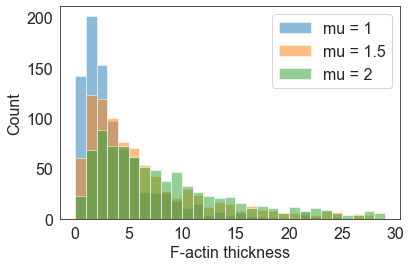

In [60]:
sigma = 1
for mu in [1,1.5,2]:
    thickness = np.random.lognormal(mu, sigma, 900)
    print(sum(thickness))
    plt.hist(thickness, alpha = 0.5, bins = np.arange(30), label = 'mu = '+str(mu))
plt.xlabel("F-actin thickness")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("Actin_thickness_muComp.png", dpi = 300)

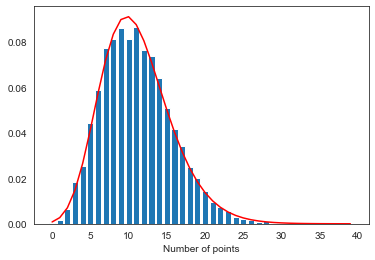

In [11]:
sns.set_style("white")
plt.figure()
allData = np.reshape(allRes, (numGrid*numGrid*10))
(s, loc, scale) = st.lognorm.fit(allData, loc = 0)
xfit = np.arange(40)
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
plt.bar(xfit, avgHist[0:40]/sum(avgHist))
plt.xlabel("Number of myosin")
plt.ylabel("PDF")
plt.savefig("myosinBinding_histogram_acBias_1_myoBias_0_lam_6.png", dpi = 300)

In [ ]:
sns.set_style("white")
plt.figure()
sns.histplot(np.reshape(MyosinPoints, (numGrid*numGrid)), binwidth = 1)
plt.xlabel("Number of points")
#plt.savefig("myosinBinding_histogram_acBias_1_myoBias_0.5.png", dpi = 300)
#plt.hist(np.reshape(MyosinPoints, (numGrid*numGrid)), bins = np.arange(np.max(MyosinPoints)))

## 2D case
In construction...

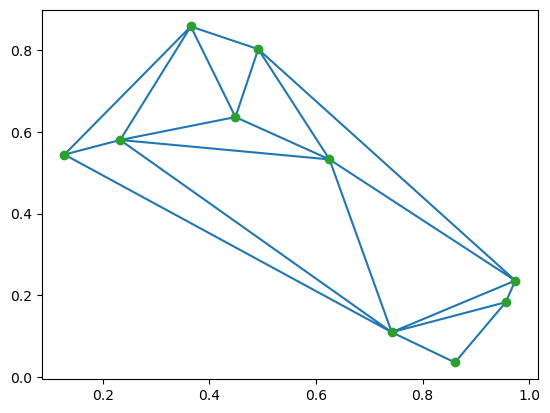

In [5]:
# Define initial network structure
numGrid = 10
coordinates = np.zeros((numGrid, 2))
for ii in range(numGrid):
    coordinates[ii, 0] = random.random()
    coordinates[ii, 1] = random.random()

tri = Delaunay(coordinates)
plt.triplot(coordinates[:,0], coordinates[:,1], tri.simplices)
plt.plot(coordinates[:,0], coordinates[:,1], 'o')
plt.show()

In [11]:
tri.simplices

array([[6, 5, 2],
       [3, 6, 7],
       [6, 3, 5],
       [3, 0, 5],
       [0, 7, 4],
       [0, 3, 7],
       [8, 9, 1],
       [0, 9, 5],
       [5, 9, 2],
       [9, 8, 2],
       [9, 0, 4]], dtype=int32)

In [10]:
coordinates.tolist()[0]

[0.2327347347226143, 0.5804723624457677]

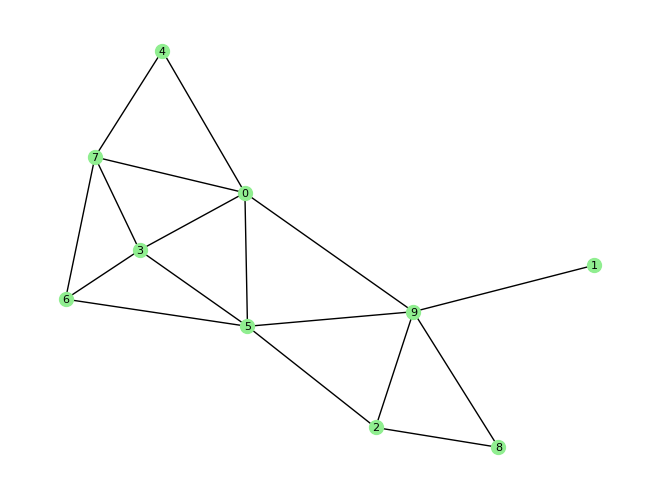

In [12]:
G = nx.Graph()
#G.add_nodes_from(coordinates.tolist())
for path in tri.simplices:
    nx.add_path(G, path)
    
nx.draw(G, with_labels=True, node_size=100, node_color='lightgreen', font_size=8)

In [5]:
tri.points[0]==coordinates[0,:]

array([ True,  True])

In [6]:
# Extract neighbors
vertex_id = 1
index_pointers, indices = tri.vertex_neighbor_vertices
result_id = indices[index_pointers[vertex_id]:index_pointers[vertex_id+1]]
result_id

array([983, 684, 436,  70, 398, 851], dtype=int32)

In [61]:
weights = np.array([.1, .2, .1, .4, .2, .3])
myoCap = 6
weights[np.array([3,5,2,7,4,2])>=myoCap] = weights[np.array([3,5,2,7,4,2])>=myoCap]*np.exp(-())
weights

array([0.1, 0.2, 0.1, 2. , 0.2, 0.3])